<a href="https://colab.research.google.com/github/taekjunkim/ImageProcessing/blob/main/FaceMorphing/FaceMorphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Python Implementation of Face Morphing**

In [2]:
### import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import dlib
import time
from IPython import display   # for update plot in a loop 

from scipy.spatial import Delaunay, Voronoi

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Prepare two photos each of which has a front face**

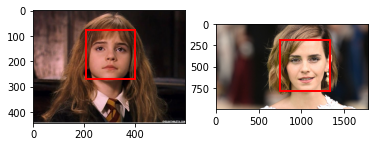

In [3]:
### Read in the source and target images
imgA = cv2.imread('/content/drive/MyDrive/Personal/FaceMorphing/EmmaWatson1.jpeg')
imgB = cv2.imread('/content/drive/MyDrive/Personal/FaceMorphing/EmmaWatson2.jpeg')

### face detection
def detect_face(img, ax_num):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml');
    img_faces = face_cascade.detectMultiScale(img, 1.1, 5); 

    plt.subplot(1, 2, ax_num); 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); 
    for (x,y,w,h) in img_faces:
        rect = Rectangle((x,y),w,h, linewidth=2, edgecolor='r', facecolor='none');
        plt.gca().add_patch(rect); 
    return img_faces; 

imgA_face = detect_face(imgA, 1); 
imgB_face = detect_face(imgB, 2); 

**2. Resize and crop the image**

*   Cropped image size: 700 x 700 
*   Face region: 500 x 500 at the center

[[207  77 194 194]] [533.50515464 198.45360825 500.         500.        ]
[[746 194 592 592]] [630.06756757 163.85135135 500.         500.        ]


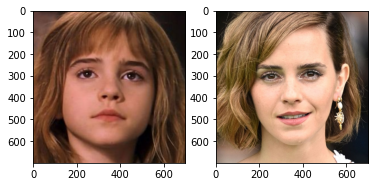

In [4]:
### resize and crop around the face
# resize an image so that the face region becomes 500px x 500px
# crop the image with 100px margin: cropped image size becomes 700px x 700px
def resize_crop(img, face, ax_num):
    h, w, c = img.shape; 

    scale_factor = 500/np.mean(face[0][2:]); 
    new_w = int(w*scale_factor); 
    new_h = int(h*scale_factor); 
    dsize = (new_w, new_h); 
    new_face = face[0]*scale_factor; 

    print(face, new_face)
    resized = cv2.resize(img, dsize); 
    anchor_x = int(new_face[0])-100; 
    anchor_y = int(new_face[1])-100; 

    cropped = resized[anchor_y:anchor_y+700, anchor_x:anchor_x+700]; 

    plt.subplot(1, 2, ax_num); 
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)); 

    return cropped; 

imgA = resize_crop(imgA, imgA_face, 1); 
imgB = resize_crop(imgB, imgB_face, 2); 

**3. Find Point Correspondences using Facial Feature Detection**
> Now, imgA and imgB are ready
>
> To morph imgA into imgB, we need to first establish pixel correspondence between the two images.




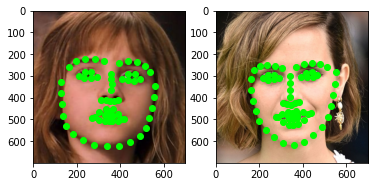

In [5]:
### find face landmarks
# use dlib library
# use pretrained model: shape_predictor_68_face_landmarks.dat 
detector = dlib.get_frontal_face_detector(); 
predictor = dlib.shape_predictor("/content/drive/MyDrive/Personal/FaceMorphing/shape_predictor_68_face_landmarks.dat"); 

def get_landmarks(img, ax_num):
    img_gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY); 
    faces = detector(img_gray)
    landmarks = predictor(image=img_gray, box=faces[0])

    plt.subplot(1,2,ax_num)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); 

    landmarks_points = []; 
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append([x,y]); 

        # Draw a circle
        plt.plot(x, y, 'o', color=(0, 1, 0))
    
    # add points at corners
    landmarks_points.append([0,0]); 
    landmarks_points.append([0,699]); 
    landmarks_points.append([699,0]); 
    landmarks_points.append([699,699]);             

    return landmarks_points; 

imgA_landmarks = get_landmarks(imgA, 1); 
imgB_landmarks = get_landmarks(imgB, 2); 

**4. Get Area Correspondences using Triangulation**

> From the previous step we have two sets of 72 (68(face) + 4(corner)) points — one set per image.
>
> On these points, we performed Delaunay triangulation and it produces 138 triangles connecting the 72 points 

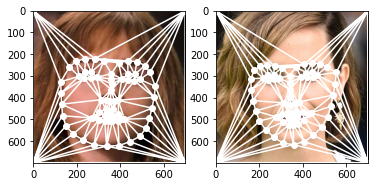

In [6]:
### triangulation
# from scipy.spatial import Delaunay
def plot_triangulation(img, points, ax_num):
    points = np.array(points); 
    triangulation = Delaunay(points); 

    plt.subplot(1,2,ax_num); 
    
    v = Voronoi(points)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.triplot(points[:,0], points[:,1], triangulation.simplices.copy(), c='w')
    plt.plot(points[:,0], points[:,1], 'wo')

    return None; 

plot_triangulation(imgA, imgA_landmarks, 1); 
plot_triangulation(imgB, imgB_landmarks, 2); 

**5. Warping images and alpha blending**

*   Calculate the location ($x_m, y_m$) of the pixel in the morphed image, imgM
  
  - Weighted average of 72 Point Correspondences from imgA and imgB
  - $x_m = (1-\alpha)x_A + \alpha x_B$
  - $y_m = (1-\alpha)y_A + \alpha y_B$

*   Calculate affine transforms 
  - We now have 72 corresponding points from imgA, imgB, and imgM
  - We now have 138 corresponding triangles from imgA, imgB, and imgM
  - Pick a triangle in imgA and the corresponding triangle in imgM
     -  Calculate the affine transform that maps the three corners of the triangle in imgA to the three corners of the corresponding triangle in imgM
  - Calculate an affine transform for every pair of 138 triangles. 
  - Repeat the process of imgB and imgM.

*   Warp triangle
  - For each triangle in imgA, use the affine transform calculated in the previous step to transform all pixels inside the triangle to imgM. Repeat this for all triangles in imgA to obtain a warped version of imgA. Similarly, obtain a warped version for imgB.

*   Alpha blend warped images
  - In the previous step we obtained warped version of imgA and imgB. 
  - These two images can be alpha blended using equation
    - $M(x_m, y_m) = (1-\alpha)A(x_a, y_a) + \alpha B(x_b, y_b)$


In [7]:
alpha_list = np.arange(0, 1.02, 0.02); 

imgM_list = []; 
for i in range(len(alpha_list)):  
    # alpha is changing
    alpha = alpha_list[i]; 

    # output image
    imgM = np.zeros(imgA.shape, dtype = imgA.dtype)

    # Calculate the landmark points in the morphed image, imgM
    imgM_landmarks = (1-alpha)*np.array(imgA_landmarks, dtype=float) + \
                         alpha*np.array(imgB_landmarks, dtype=float); 

    # triangulation in imgM
    imgM_tri = Delaunay(imgM_landmarks); 

    for t in range(len(imgM_tri.simplices)): 
        # which point# are in this triangle
        simplices_now = imgM_tri.simplices[t]; 

        # x,y values for this triangle in imgA, imgB, imgM
        imgA_points = []; 
        imgB_points = []; 
        imgM_points = []; 
        for p in range(3):
            x = imgA_landmarks[simplices_now[p]][0]; 
            y = imgA_landmarks[simplices_now[p]][1]; 
            imgA_points.append([x,y]); 

            x = imgB_landmarks[simplices_now[p]][0]; 
            y = imgB_landmarks[simplices_now[p]][1]; 
            imgB_points.append([x,y]); 

            x = imgM_landmarks[simplices_now[p]][0]; 
            y = imgM_landmarks[simplices_now[p]][1]; 
            imgM_points.append([x,y]); 


        # Find bounding rectangle for each triangle
        rectA = cv2.boundingRect(np.float32([imgA_points]))
        rectB = cv2.boundingRect(np.float32([imgB_points]))
        rectM = cv2.boundingRect(np.float32([imgM_points]))

        # Offset points by left top corner of the respective rectangles
        from_rectA = []
        from_rectB = []
        from_rectM = []

        for i in range(0, 3):
            from_rectM.append(((imgM_points[i][0] - rectM[0]),(imgM_points[i][1] - rectM[1]))); 
            from_rectA.append(((imgA_points[i][0] - rectA[0]),(imgA_points[i][1] - rectA[1]))); 
            from_rectB.append(((imgB_points[i][0] - rectB[0]),(imgB_points[i][1] - rectB[1]))); 

        # Get mask by filling triangle
        mask = np.zeros((rectM[3], rectM[2], 3), dtype = np.float32)
        cv2.fillConvexPoly(mask, np.int32(from_rectM), (1.0, 1.0, 1.0), 16, 0)

        # small rectangular patches of imgA, imgB
        imgA_patch = imgA[rectA[1]:rectA[1] + rectA[3], rectA[0]:rectA[0] + rectA[2]]; 
        imgB_patch = imgB[rectB[1]:rectB[1] + rectB[3], rectB[0]:rectB[0] + rectB[2]]; 

        # Given a pair of triangles, find the affine transform.
        warpMat_A = cv2.getAffineTransform( np.float32(from_rectA), np.float32(from_rectM) )
        warpMat_B = cv2.getAffineTransform( np.float32(from_rectB), np.float32(from_rectM) )

        # Apply the Affine Transform just found to the src image
        size = (rectM[2], rectM[3]); 
        warpedA_patch = cv2.warpAffine( imgA_patch, warpMat_A, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )        
        warpedB_patch = cv2.warpAffine( imgB_patch, warpMat_B, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )        

        # Alpha blend rectangular patches
        warped_patch = (1.0 - alpha) * warpedA_patch + alpha * warpedB_patch; 

        # Copy triangular region of the rectangular warped patch to the output image
        imgM[rectM[1]:rectM[1]+rectM[3], rectM[0]:rectM[0]+rectM[2]] = \
        imgM[rectM[1]:rectM[1]+rectM[3], rectM[0]:rectM[0]+rectM[2]] * ( 1 - mask ) + warped_patch * mask

    imgNow = cv2.resize(imgM, (250,250)); 
    imgM_list.append(cv2.cvtColor(imgNow, cv2.COLOR_BGR2RGB)); 
    print(f'alpha={alpha} was done'); 

alpha=0.0 was done
alpha=0.02 was done
alpha=0.04 was done
alpha=0.06 was done
alpha=0.08 was done
alpha=0.1 was done
alpha=0.12 was done
alpha=0.14 was done
alpha=0.16 was done
alpha=0.18 was done
alpha=0.2 was done
alpha=0.22 was done
alpha=0.24 was done
alpha=0.26 was done
alpha=0.28 was done
alpha=0.3 was done
alpha=0.32 was done
alpha=0.34 was done
alpha=0.36 was done
alpha=0.38 was done
alpha=0.4 was done
alpha=0.42 was done
alpha=0.44 was done
alpha=0.46 was done
alpha=0.48 was done
alpha=0.5 was done
alpha=0.52 was done
alpha=0.54 was done
alpha=0.56 was done
alpha=0.58 was done
alpha=0.6 was done
alpha=0.62 was done
alpha=0.64 was done
alpha=0.66 was done
alpha=0.68 was done
alpha=0.7000000000000001 was done
alpha=0.72 was done
alpha=0.74 was done
alpha=0.76 was done
alpha=0.78 was done
alpha=0.8 was done
alpha=0.8200000000000001 was done
alpha=0.84 was done
alpha=0.86 was done
alpha=0.88 was done
alpha=0.9 was done
alpha=0.92 was done
alpha=0.9400000000000001 was done
alpha=0

In [10]:
import imageio
imageio.mimsave('EmmaWatson.gif', imgM_list, duration = 0.1)

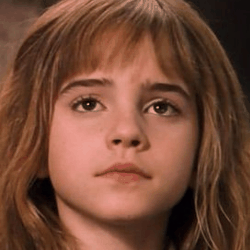

In [11]:
from IPython.display import Image
Image(open('EmmaWatson.gif','rb').read())